In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os import path
import sys
sys.path.insert(0, path.abspath('../'))

from src.mcmc import Chain
from src import parse_model_parameter_file


log="no_log"
pca="no_pca"
log2="nolog"
pca2="nopca"
setup="allenergies:allsystems:base-star-eta:3.0:nostarptcut"
setup2="allenergies:allsystems:base-star-eta:3.0:nostarptcut"
suff=""
emu="PCGP"



emuPath=["/home/niklas/Desktop/lustre/good_bayes/inference/actual/emulator_full/"+log+"/"+pca+"/"+emu+"/data:"+setup2+"_"+log2+"_"+pca2+"_"+emu+suff]
exp_path = "/home/niklas/Desktop/lustre/good_bayes/inference/exp/data:"+setup+".pkl"
model_par = '/home/niklas/Desktop/lustre/good_bayes/inference/training_points/configs/config_AuAu_200_bulk_scan_central.yaml'
mymcmc = Chain(expdata_path=exp_path, model_parafile=model_par)

mymcmc.loadEmulator(emuPath)


[INFO][mcmc] Initializing MCMC ...
[INFO][mcmc] Final Markov Chain results will be saved in mcmc/chain.pkl
[INFO][mcmc] Loading the model parameters space from /home/niklas/Desktop/lustre/good_bayes/inference/training_points/configs/config_AuAu_200_bulk_scan_central.yaml ...
[INFO][mcmc] Run MCMC with emcee...
[INFO][mcmc] Loading the experiment data from /home/niklas/Desktop/lustre/good_bayes/inference/exp/data:allenergies:allsystems:base-star-eta:3.0:nostarptcut.pkl ...
[INFO][mcmc] Experimental dataset size: 168
[INFO][mcmc] Number of Emulators: 1


In [6]:
with open(exp_path,'rb') as file:
    loaded_data = pickle.load(file)

[INFO][mcmc] Experimental dataset size: 168


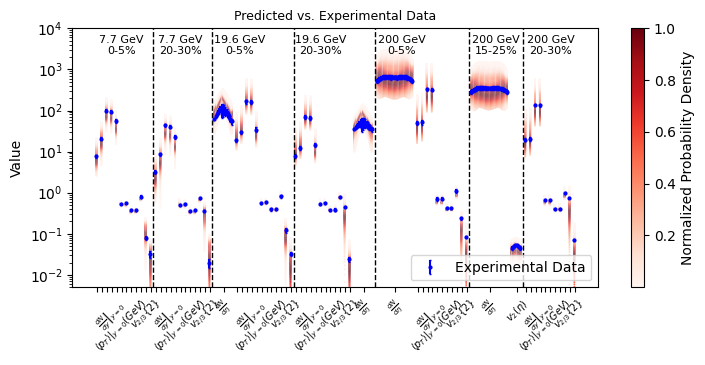

In [ ]:

import pickle
from os import path
from scipy.stats import gaussian_kde

PARAMETER_NAMES = [
    r'$\tau_{IC,scale}\;[{\rm fm}]$',
    r'$a_{h,\eta}$',
    r'$a_{l,\eta}$',
    r'$\epsilon_{\rm sw}\;[{\rm GeV/fm^3}]$',
    r'$(\eta/s)_{\rm min}$',
    r'$a_{\mu_B}$', #etsscale_mub
    r'$b_{\mu_B}$',#etasshiftmub
    r'$R_{\rm g}$',
    r'$R_{\rm z}$',
    r'$T_{\eta, \rm 0}\;[{\rm GeV}]$',
    r'$(\zeta/s)_{\rm 0}$',
    r'$(\epsilon)_{\zeta,\rm 0 }\;[{\rm GeV/fm^3}]$',
    r'$\sigma_{\zeta, \rm -}\;[{\rm GeV}]$',
    r'$\sigma_{\zeta, \rm +}\;[{\rm GeV}]$',
    r'$\sigma_{\rm AB, scale}$'
]


import matplotlib.pyplot as plt
import numpy as np
import re
import pickle
import matplotlib.transforms as mtransforms




# Function to extract info from the filename
def extract_info_from_filename(filename):
    parts = filename.split('_')
    energy = parts[1]
    centrality = parts[2]
    observable = '_'.join(parts[3:])
    return energy, centrality, observable

# Function to convert filenames to appropriate labels
def convert_to_notation(filename):
    filename = re.sub(r'(exp_|\.pkl|../latent_pickled/)', '', filename)
    filename = re.sub(r'star_v(.*)_pT', r'starv\1pt', filename)
    filename = re.sub(r'star_v', 'starv', filename)
    filename = re.sub(r'phenix_pT_v', 'phenixptv', filename)
    filename = re.sub(r'stareta_spectra', 'etas', filename)
    filename = re.sub(r'eta_spectra', 'etas', filename)
    filename = re.sub(r'y_spectra', 'ys', filename)
    filename = re.sub(r'pT_spectra', 'pTs', filename)
    filename = re.sub(r'phobos_v2_spectra', 'v2eta', filename)
    
    observables = {
        'etas': r'$\frac{dN}{d\eta}$',
        'ys': r'$\frac{dN}{dy}$',
        'pTs': r'$\frac{dN}{d(p_T)}$',
        'dNdy': r'$\left.\frac{dN}{dy}\right|_{y=0}$',
        'meanpT': r'$\langle p_T \rangle |_{y=0} (GeV)$',
        'starv2': r'$\left.v_{2/3}\right.\{2\}$',
        'starv3': r'',
        'phenixptv2': r'$v_2(p_T)$',
        'phenixptv3': r'$v_3(p_T)$',
        'starv2pt': r'$v_2(p_T)$',
        'starv3pt': r'$v_3(p_T)$',
        'v2eta': r'$v_2(\eta)$'
    }
    
    particles = {
        'kminus': r'K^-',
        'kplus': r'K^+',
        'p': 'p',
        'pbar': r'\bar{p}',
        'piminus': r'\pi^-',
        'piplus': r'\pi^+'
    }
    parts = filename.split('_')
    particle = ''
    observable = ''
    integrated = False
    for part in parts:
        if part in observables:
            observable = observables[part]
        elif part in particles:
            particle = particles[part]
        elif part == 'integrated':
            integrated = True

    if integrated and ("star" not in parts[1]) and ((parts[2] == 'piplus' and parts[1]  == 'dNdy') or (parts[2]  == 'kminus' and parts[1] == 'meanpT')):
        pass
    elif integrated and particle != '':
        observable = ''
    elif ('ys' in filename or 'pTs' in filename or integrated) and not 'star' in filename:
        observable = observable[:-1] + f'({particle})$'

    return observable


# Generate the data_list based on loaded data
data_list = []
for i, name in enumerate(loaded_data[0]["name"]):
    energy, centrality, observable = extract_info_from_filename(name)
    start = loaded_data[0]["lim"][i]
    end = loaded_data[0]["lim"][i + 1]
    data_list.append((energy, centrality, observable, start, end, i))

# Define a custom order for energies (e.g. 7.7, 19.6, 200 GeV)
energy_order = {'7.7': 0, '19.6': 1, '200': 2}
centrality_order = {'05': 0, '1525': 1, "2030": 2}
centrality_dict = {'05': '0-5%', '1525': '15-25%', '2030': '20-30%'}

# Sort the list by energy, then by centrality
data_list.sort(key=lambda x: (energy_order[x[0]], centrality_order[x[1]]))

# Step 1: Reorder expData and postPred according to data_list
reordered_expData = []
reordered_expData_std = []
reordered_postPred = []
reordered_postPredstd = []

current_pos = 0

#parameter=[[1.0, 0.0, 0.0, 0.5, 0.08,0.,0.,1.0,1.0,0.15,0.0,10.,0.05,0.05,1.0 ],[1.0, 0.0, 0.0, 0.5, 0.08,0.,0.,1.0,1.0,0.15,0.0,10.,0.04,0.06,1.0 ]]
#postPred = mymcmc._predict(np.array(samples)) #convert the 15 parameters to posterior predictons
prior_ranges = [
    (0.8,2.5),
    (-15,1.75),
    (-15,1),
    (0.25,0.75),
    (0.001,0.35),
    (-0.8,9),
    (-0.3,0.8),
    (0.2,2.2),
    (0.2,3),
    (0.09,0.25),
    (0,0.2),
    (0.5,40),
    (0.005,0.1),
    (0.01,0.15),
    (0.8,1.2),
] 
num_samples = 1500

# Initialize the samples array
samples = np.zeros((num_samples, len(prior_ranges)))

# Generate samples
for i in range(len(prior_ranges)):
    low, high = prior_ranges[i]
    samples[:, i] = np.random.uniform(low, high, num_samples)

# Use the sample set (postPred) instead of the means
postPred = mymcmc._predict(samples)
postPred = postPred[0].transpose()
expData = mymcmc._read_in_exp_data_pickle(exp_path)

for energy, centrality, observable, start, end, original_index in data_list:
    reordered_expData.append(expData[0].flatten()[start:end])
    reordered_expData_std.append(np.sqrt(np.diagonal(expData[1])).flatten()[start:end])
    reordered_postPred.append(postPred[start:end])

    reordered_expData.append([0, 0, 0])
    reordered_expData_std.append([0, 0, 0])
    reordered_postPred.append([0, 0, 0])
    reordered_postPredstd.append([0, 0, 0])

# Flatten the reordered lists for experimental data and predicted means/stds
reordered_expData = np.concatenate(reordered_expData)
reordered_expData_std = np.concatenate(reordered_expData_std)


non_zero_mask = (reordered_expData != 0)
plot_expData = np.where(non_zero_mask, reordered_expData, np.nan)
plot_expData_std = np.where(non_zero_mask, reordered_expData_std, 0)
# Prepare for plotting
plt.figure(figsize=(7.5, 7.5/2))

# Loop through each observable and apply KDE to the sample set for that observable
x = np.arange(len(reordered_postPred))
pos=0
for i in x:
    # Check if the current entry is [0, 0, 0]
    if np.array_equal(reordered_postPred[i], [0, 0, 0]):
        pos += 3
        continue

    observable_samples = np.array(reordered_postPred[i])


    # Case 2: List of samples for a list of values
    for val in observable_samples:
        kde = gaussian_kde(val.flatten())  # Flatten the samples array for KDE
        density_x = np.linspace(val.min(), val.max(), 300)
        density = kde(density_x)

        density /= density.max()

        # Plot the density as a gradient
        plt.scatter(np.full_like(density_x, pos), density_x, c=density, cmap='Reds', s=2, edgecolor='White', linewidth=0.1)
        pos += 1

# Overlay the experimental data with error bars
plt.errorbar(range(len(reordered_expData)), plot_expData, yerr=plot_expData_std, fmt='o', label='Experimental Data', color='blue', ecolor='blue', capsize=1, markersize=2)

#plt.xlabel('Observable')
plt.ylabel('Value')
plt.title('Predicted vs. Experimental Data',fontsize=9)
plt.yscale("log")
plt.legend(loc="lower right")
plt.colorbar(label='Normalized Probability Density')
current_x_pos = 0
xticksPos = []
xticksLabel = []
trans = mtransforms.blended_transform_factory(plt.gca().transData, plt.gca().transAxes)
for i, (energy, centrality, observable, start, end, original_index) in enumerate(data_list):
    mid_pos = current_x_pos + (end - start) / 2 +3*i
    xticksPos.append(mid_pos)
    xticksLabel.append(convert_to_notation(observable))
    if i == 0:
        plt.text(current_x_pos + 3 * i + 20.5, 0.9, f'{energy} GeV\n{centrality_dict[centrality]}', 
                horizontalalignment='center', fontsize=8, transform=trans)
    if i > 0 and (data_list[i][0] != data_list[i-1][0] or data_list[i][1] != data_list[i-1][1]):
        plt.axvline(x=current_x_pos+3*i-1.5, color='black', linestyle='--', linewidth=1)
        
        # Create a transform that only affects the y-coordinate
        

        plt.text(current_x_pos + 3 * i + 20.5, 0.9, f'{energy} GeV\n{centrality_dict[centrality]}', 
                horizontalalignment='center', fontsize=8, transform=trans)
    
    current_x_pos += (end - start)

plt.xticks(xticksPos, xticksLabel, rotation=45, fontsize=7)
plt.tight_layout()
plt.ylim([5e-3,1e4])
plt.savefig("./plots/prioobs.png", dpi=500)

plt.show()